In [7]:
import random
from rdkit import Chem
import pandas as pd
from ast import literal_eval
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import plotly.express as px
import plotly.graph_objects as go

In [8]:
df = pd.read_csv("gephi_graphs/graph_data.csv")

In [9]:
from collections import Counter
from ast import literal_eval
counter = Counter()

df_summs = pd.read_csv('../../results/schembl_summs_v5_final.csv')
df_summs = df_summs['summarizations'].apply(literal_eval)
# count each label in summarizations
for i in range(len(df_summs)):
    counter.update(df_summs[i])

In [10]:
# df_fp.to_pickle("../../results/schembl_summs_v5_final_fp_bitvec.pkl")
df_fp = pd.read_pickle("../../results/schembl_summs_v5_final_fp_bitvec.pkl")
df_fp["summarizations"] = df_fp["summarizations"].apply(literal_eval)


In [11]:
tsne_df = pd.read_csv("./chef_v5_fp_tsne_p500.csv")
tsne_df["summarizations"] = tsne_df["summarizations"].map(literal_eval)

<Figure size 640x480 with 0 Axes>

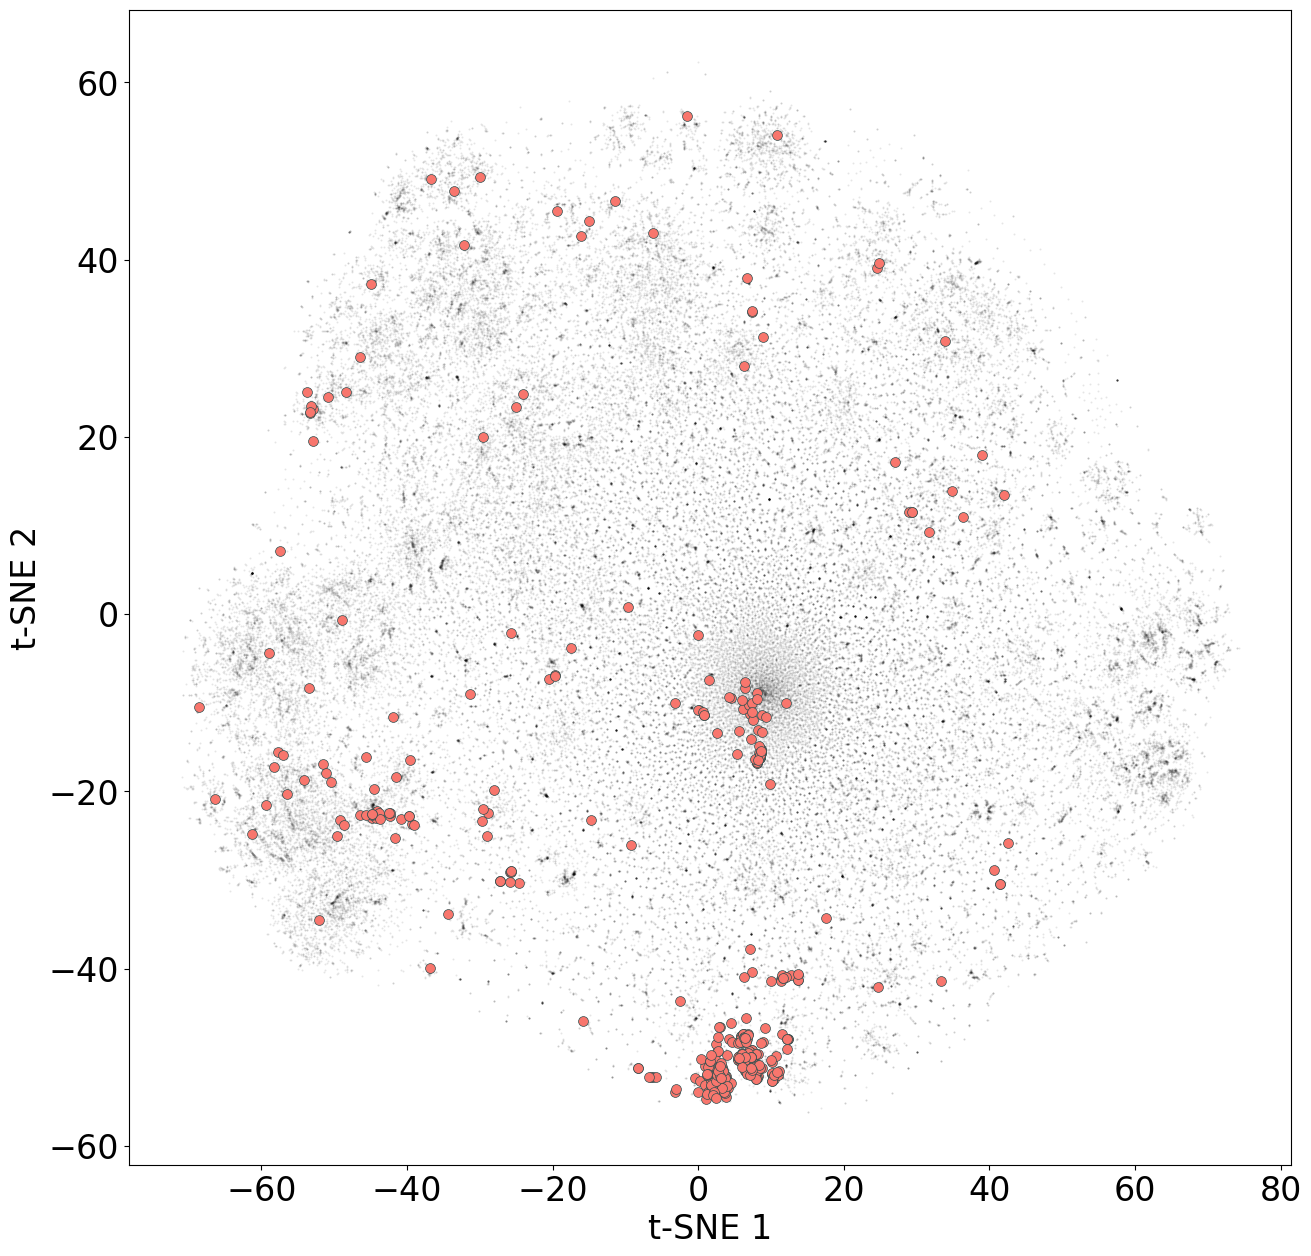

In [50]:
for term_1 in ["electroluminescence", "hcv", "anti-microbial", "antiviral", "polymer", "perfume", "opioid", "mtor", "cannabinoid", "crystal", "protease"]:
    # swap source and target if term_1 is in target. This ensures that term_1 is always in source
    df.loc[df["target"] == term_1, ["target", "source"]] = df.loc[df["target"] == term_1, ["source", "target"]].values
    df["source_global_count"] = df['source'].apply(lambda x: counter[x])
    df["target_global_count"] = df['target'].apply(lambda x: counter[x])

    # get 10 closest terms to term_1 that aren't very common
    close_terms = df.loc[df["source"] == term_1].loc[df["target_global_count"] < 1000].sort_values(by="weight", ascending=False).head(10)["target"].values

    # for each row in dataframe that contains term_1 in 'summarizations'
    df_term_1 = df_fp[df_fp["summarizations"].map(lambda x: any(term_1 == word for word in x))].reset_index(drop=True)

    # for each row in dataframe that contains any term in close_terms in 'summarizations'
    df_close_terms = df_fp[df_fp["summarizations"].map(lambda x: any(term in x for term in close_terms))].reset_index(drop=True)

    # choose a random 10 terms not found in close_terms or term_1
    illegal_terms = close_terms + [term_1]

    # Compute mean distance from term_1 to the closest term in term_2
    fp_tanimoto = np.zeros((len(df_term_1)))
    for i in range(len(df_term_1)):
        sim = np.array(DataStructs.BulkTanimotoSimilarity(df_term_1['fingerprint'].iloc[i], df_close_terms['fingerprint']))
        
        # remove values if above 0.99
        # sim = sim[sim != 1.0]
        fp_tanimoto[i] = np.max(sim)

    neighbor_mean = np.mean(fp_tanimoto)
    neighbor_std = np.std(fp_tanimoto)
    neighbor_conf = np.std(fp_tanimoto)*1.96/np.sqrt(len(fp_tanimoto))

    print("Graph neighbors")
    print("Mean", neighbor_mean)
    print("Std", neighbor_std)
    print("95 conf", neighbor_conf)



    # null similarity. select random 10 labels each time
    fp_tanimoto_null = np.zeros((len(df_term_1)))
    random.seed(hash(term_1))
    for i in range(len(df_term_1)):
        rand_10_terms = random.sample([term for term in counter if term not in illegal_terms and counter[term] < 1000], 10)
        df_random_terms = df_fp[df_fp["summarizations"].map(lambda x: any(term in x for term in rand_10_terms))].reset_index(drop=True)
        sim = np.array(DataStructs.BulkTanimotoSimilarity(df_term_1['fingerprint'].iloc[i], df_random_terms['fingerprint']))

        fp_tanimoto_null[i] = np.max(sim)

    random_mean = np.mean(fp_tanimoto_null)
    random_std = np.std(fp_tanimoto_null)
    random_conf = np.std(fp_tanimoto_null)*1.96/np.sqrt(len(fp_tanimoto_null))

    print("Null")
    print("Mean", random_mean)
    print("Std", random_std)
    print("95 conf", random_conf)

    # clear plots
    plt.clf()

    plot_df = pd.DataFrame(columns=['group', 'value'])
    plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'null', 'value': fp_tanimoto_null})])
    plot_df = pd.concat([plot_df, pd.DataFrame({'group': 'graph', 'value': fp_tanimoto})])


    # make combined plot
    fig, ax = plt.subplots(figsize=(4, 4))

    # add first plot. Make conf interval have caps. Set confidence interval to 95% (variable)
    sns.barplot(x='group', y='value', data=plot_df, color='white', ax=ax, palette=sns.color_palette(), dodge=False, alpha=0.6, ec='k', linewidth=1, capsize=0.1, errwidth=1.5, errcolor='k', errorbar=('ci', 95))

    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel(f'Max Tc')
    # set x axis labels
    ax.set_xticklabels([f'Random', f'Closest\nNeighbors'], fontsize=12)
    ax.set_ylim(0, 1)

    # prep data for statistical test
    # add statistical annotations
    annotator = Annotator(data=plot_df, x='group', y='value', pairs = [('null', 'graph')], ax=ax)
    annotator.configure(test="t-test_ind", text_format='simple', loc='inside', verbose=2)
    # line up width with means of distributions
    annotator.apply_test()
    annotator.annotate()


    plt.savefig(f'tsne_plots/term_{term_1}_neighbors_max_tc.png', dpi=300, bbox_inches='tight')

    # write close_terms, means, and stds to file
    with open(f'tsne_plots/term_{term_1}_neighbors_max_tc.txt', 'w') as f:
        f.write(f'Term: {term_1}\n')
        f.write(f'Close terms: {close_terms}\n')
        f.write(f'Mean: {neighbor_mean}\n')
        f.write(f'Std: {neighbor_std}\n')
        f.write(f'95% Conf: {neighbor_conf}\n')
        f.write(f'Random terms: {rand_10_terms}\n')
        f.write(f'Random mean: {random_mean}\n')
        f.write(f'Random std: {random_std}\n')
        f.write(f'Random 95% conf: {random_conf}\n')
        f.write(f"n_mols with term_1: {len(fp_tanimoto)}\n")
        f.write(f"n_mols with neighbor terms: {len(df_close_terms)}\n")
        f.write(f"n_mols with random terms: {len(df_random_terms)}\n")



    # NOTE Plotly tsne plots

    # ggplot2 colors
    colors = [
        "#F8766D",
        "#7CAE00",
        "#00BFC4",
        "#C77CFF",
        "#C7C777",
        "#FFC90E",
        "#00B0F6",
        "#E76BF3",
        "#FF905C",
        "#00BE67",
    ]





    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.scatter(
        tsne_df['fp_tsne_x'],
        tsne_df['fp_tsne_y'],
        s=2,
        alpha=0.1,
        c="#000000",
        linewidths=0,
        edgecolors="#000000",
        label="_nolegend_"
    )

    for label, color in zip(close_terms, colors):
        plt.scatter(
            tsne_df[tsne_df["summarizations"].map(lambda x: any(label == word for word in x))]['fp_tsne_x'],
            tsne_df[tsne_df["summarizations"].map(lambda x: any(label == word for word in x))]['fp_tsne_y'],
            s=50,
            alpha=0.8,
            c=color,
            linewidths=0.5,
            edgecolors="DarkSlateGrey",
        )

    # remove first label from legend
    plt.legend(close_terms, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
    # axis numbers size 18
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("t-SNE 1", fontsize=24)
    plt.ylabel("t-SNE 2", fontsize=24)

    plt.savefig(f'tsne_plots/term_{term_1}_tsne_10_nearest_neighbors.png', dpi=300, bbox_inches='tight')
    plt.axis('off')
    plt.savefig(f'tsne_plots/term_{term_1}_tsne_10_nearest_neighbors_noaxis.png', dpi=300, bbox_inches='tight')


    



    plt.clf()
    plt.figure(figsize=(15, 15))
    plt.scatter(
        tsne_df['fp_tsne_x'],
        tsne_df['fp_tsne_y'],
        s=2,
        alpha=0.1,
        c="#000000",
        linewidths=0,
        edgecolors="#000000",
        label="_nolegend_"
    )

    plt.scatter(
        tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))]['fp_tsne_x'],
        tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))]['fp_tsne_y'],
        s=50,
        alpha=1,
        c="#F8766D",
        linewidths=0.5,
        edgecolors="DarkSlateGrey",
    )

    # remove first label from legend
    plt.legend([term_1,], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
    # axis numbers size 18
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("t-SNE 1", fontsize=24)
    plt.ylabel("t-SNE 2", fontsize=24)

    plt.savefig(f"tsne_plots/term_{term_1}_tsne.png", dpi=300, bbox_inches='tight')
    plt.axis('off')
    plt.savefig(f"tsne_plots/term_{term_1}_tsne_noaxis.png", dpi=300, bbox_inches='tight')
    # legend off
    plt.legend([],[], frameon=False)
    plt.savefig(f"tsne_plots/term_{term_1}_tsne_noaxis_nolegend.png", dpi=300, bbox_inches='tight')

    plt.axis('on')
    plt.savefig(f"tsne_plots/term_{term_1}_tsne_nolegend.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

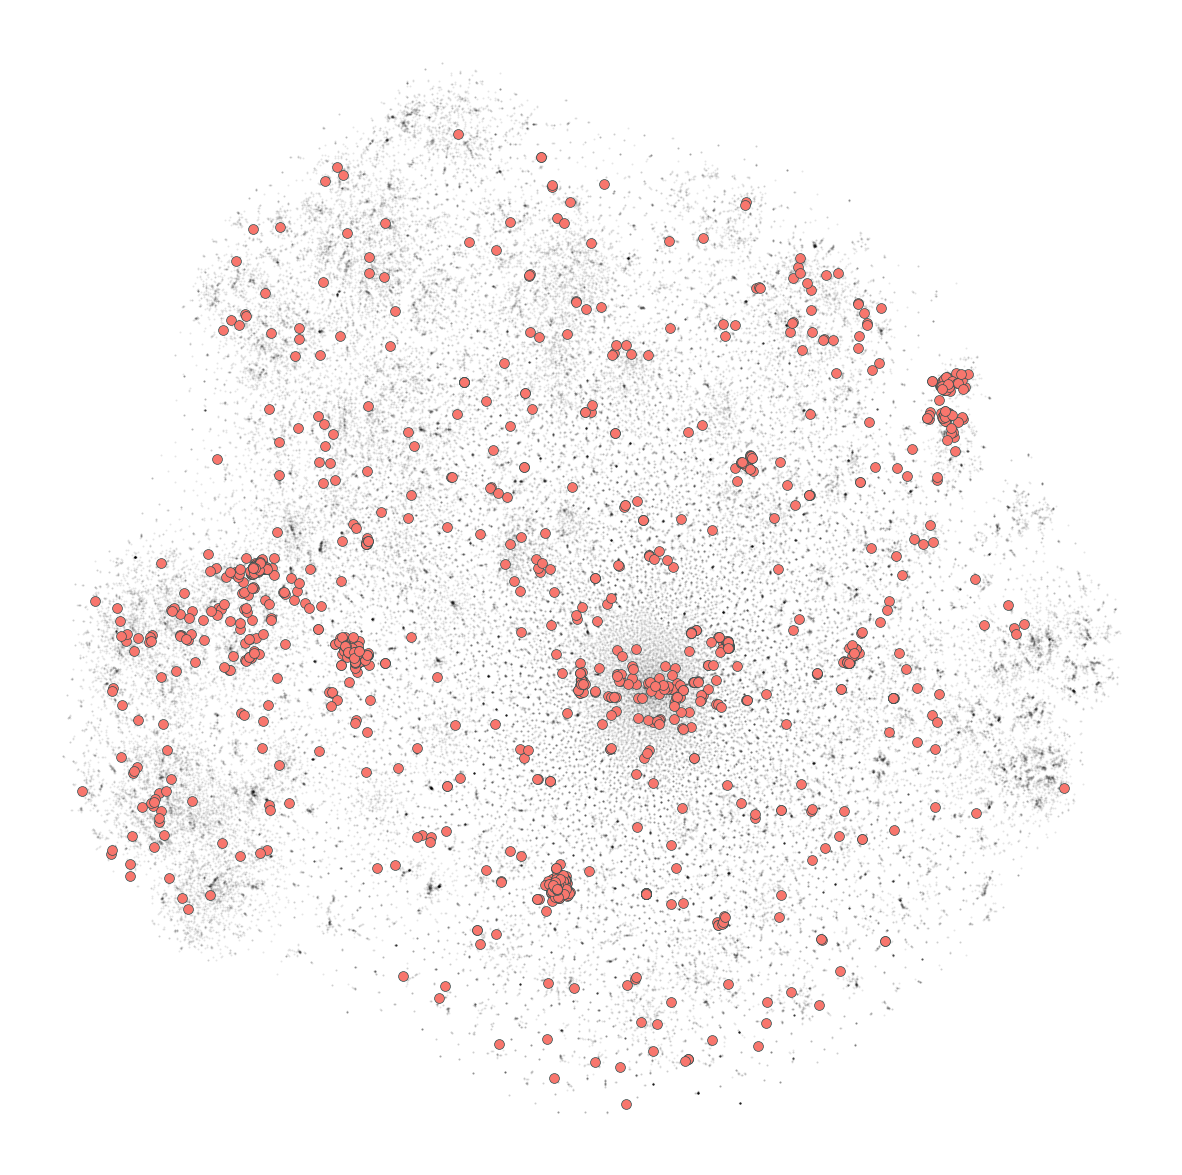

In [ ]:
# tsne_df = pd.read_csv("./tsne_data/chef_v5_fp_tsne_p500.csv")
# tsne_df["summarizations"] = tsne_df["summarizations"].map(literal_eval)

# term_1 = "hcv"


# plt.clf()
# plt.figure(figsize=(15, 15))
# plt.scatter(
#     tsne_df['fp_tsne_x'],
#     tsne_df['fp_tsne_y'],
#     s=2,
#     alpha=0.1,
#     c="#000000",
#     linewidths=0,
#     edgecolors="#000000",
# )

# plt.scatter(
#     tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))]['fp_tsne_x'],
#     tsne_df[tsne_df["summarizations"].map(lambda x: any(term_1 == word for word in x))]['fp_tsne_y'],
#     s=50,
#     alpha=1,
#     c="#F8766D",
#     linewidths=0.5,
#     edgecolors="DarkSlateGrey",
# )

# plt.axis('off')
# plt.savefig(f"test_{term_1}_tsne.png", dpi=300, bbox_inches='tight', pad_inches=0)